In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
pi = np.pi
np.set_printoptions(precision=3)

In [145]:
def createPeriodicSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0, per=1)
    return tck

def createSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0)
    return tck

def computeNodeLocations( N, tck ):
    t = np.linspace( 0, 1, N )
    x, y = interpolate.splev(t, tck)
    return x, y

def computeNormParameterizationDerivative( N, tck ):
    t = np.linspace( 0, 1, N )
    dx_dt, dy_dt = interpolate.splev(t, tck, der=1)
    ds_dt = np.sqrt( dx_dt**2 + dy_dt**2 )
    return ds_dt

def computeRadial( N, tck ):
    t = np.linspace( 0, 1, N )
    rx, ry = interpolate.splev(t, tck)
    norm = np.sqrt( rx**2 + ry**2 )
    return rx/norm, ry/norm

def computeTangent( N, tck ):
    t = np.linspace( 0, 1, N )
    tx, ty = interpolate.splev(t, tck, der=1)
    norm = np.sqrt( tx**2 + ty**2 )
    return tx/norm, ty/norm

def computeNormal( N, tck ):
    t = np.linspace( 0, 1, N )
    nx, ny = interpolate.splev(t, tck, der=2)
    norm = -np.sqrt( nx**2 + ny**2 )
    return nx/norm, ny/norm

def computeBinormal( N, tck ):
    tx, ty = computeTangent( N, tck )
    nx, ny = computeNormal( N, tck )
    tangentVector = np.vstack( (tx, ty) )
    normalVector = np.vstack( (nx, ny) )
    binormal = np.cross( np.transpose(tangentVector), np.transpose(normalVector) )
    return -binormal
    
def computeGreenNormal2D( x, y, xj, yj , normalx, normaly ):
    rj2 = (x - xj)**2 + (y - yj)**2
    dGdr = ( 1 / 2 / pi ) / rj2 
    gradrn = normalx * (x - xj) + normaly * (y - yj)
    return -dGdr * gradrn




/Users/daniellam/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][128]=x[0][0]
  (i, m, i)))
/Users/daniellam/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][128]=x[1][0]
  (i, m, i)))


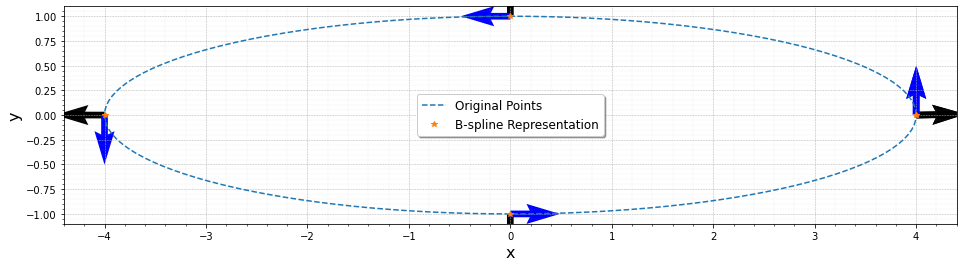

In [146]:
M = 128 + 1
N = 4 + 1

## create geometry
a = 4
b = 1

t = np.linspace( 0, 1, M )
X = a * np.cos( 2 * pi * t )
Y = b * np.sin( 2 * pi * t )

## create B-spline representation
tck = createPeriodicSplines( X[:-1], Y[:-1])
x, y = computeNodeLocations( N, tck )
quiverx, quivery = computeNodeLocations( N, tck )
tx, ty = computeTangent( N, tck )
nx, ny = computeNormal( N, tck )


fig, ax = plt.subplots(figsize=(16, 4))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='x', fontsize=16)
plt.ylabel(ylabel='y', fontsize=16)
plt.plot( X, Y, '--', markersize=10, label="Original Points")
plt.plot( x, y, '*', label="B-spline Representation")
plt.quiver( quiverx, quivery, nx, ny )
plt.quiver( quiverx, quivery, tx, ty, color='b' )
legend = ax.legend(bbox_to_anchor=(.5, .5), loc='center', shadow=True, fontsize='large')






In [147]:
def assembleMatrixSystem1( X, Y, N, U0, alpha ):
    ## compute geometric information
    tck = createPeriodicSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    theta = np.arctan2( y[:], x[:] )
    ds_dt = computeNormParameterizationDerivative( N+1, tck )
    nx, ny = computeNormal( N+1, tck )
    binormal = computeBinormal( N+1, tck )

    ## correct normal direction
    nx = binormal * nx
    ny = binormal * ny
    
    ## generate system of equations
    A = np.identity( N )
    b = np.zeros( N )
    dt = 1/ (N)
    for i in range( N ):
#         b[i] = U0 * x[i]
        b[i] = U0 * ( x[i] * np.cos( alpha * pi / 180 ) +  y[i] * np.sin( alpha * pi / 180 ) )
        for j in range( N ):
            ## if i == j, then the coefficient influence is zero
            if (i != j):
                A[i, i] = A[i, i] - ( computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j] ) ) * ds_dt[j] * dt / 2
                A[i, j] = A[i, j] + ( computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j] ) ) * ds_dt[j] * dt / 2
            if (i != j+1) and ( j + 1 != N):
                A[i, i] = A[i, i] - ( computeGreenNormal2D( x[i], y[i], x[j+1], y[j+1], nx[j+1], ny[j+1] ) ) * ds_dt[j+1] * dt / 2
                A[i, j+1] = A[i, j+1] + ( computeGreenNormal2D( x[i], y[i], x[j+1], y[j+1], nx[j+1], ny[j+1] ) ) * ds_dt[j+1] * dt / 2
            if (i != j+1) and ( j + 1 == N):
                A[i, i] = A[i, i] - ( computeGreenNormal2D( x[i], y[i], x[j+1], y[j+1], nx[j+1], ny[j+1] ) ) * ds_dt[j+1] * dt / 2
                A[i, 0] = A[i, 0] + ( computeGreenNormal2D( x[i], y[i], x[j+1], y[j+1], nx[j+1], ny[j+1] ) ) * ds_dt[j+1] * dt / 2
    
    return x[:-1], y[:-1], theta[:-1], A, b




/Users/daniellam/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][511]=x[0][0]
  (i, m, i)))
/Users/daniellam/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][511]=x[1][0]
  (i, m, i)))


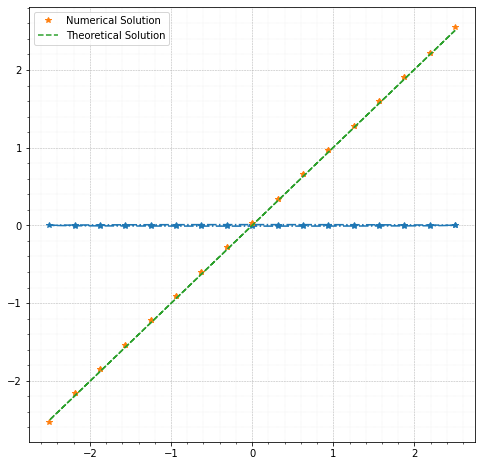

In [155]:
N = 32
U0 = 1 
alpha = 0

## create geometry
t = np.linspace( 0, 1, 512 )
dt = t[1] - t[0] 

a = 2.5
b = .01
c = (a**2-b**2)**.5

X = .5*(a+b) * np.cos( 2 * pi * t )
Y = .5*(a+b) * np.sin( 2 * pi * t )

Z = X + 1j * Y ## circular
z = Z + c**2/(4*Z) ## elliptical
X = np.real(z)
Y = np.imag(z)

## theoretical solution
eta = np.arctan2(np.imag(Z), np.real(Z))
w = (a+b)*U0*np.cos(eta - alpha*pi/180)

## create system of equations
x, y, theta, A, b = assembleMatrixSystem1( X[:-1], Y[:-1], N, U0, alpha )

## solve system of equations
phi = np.linalg.solve( A, b )

## plot solution
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()

ax.plot( np.concatenate( (x,[x[0]]) ), np.concatenate( (y,[y[0]]) ), '-.*' )

ax.plot( x, phi, '*',label="Numerical Solution" )
ax.plot( np.real(z), np.real(w), '--', label="Theoretical Solution" )
ax.legend()




/Users/daniellam/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][511]=x[0][0]
  (i, m, i)))
/Users/daniellam/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][511]=x[1][0]
  (i, m, i)))


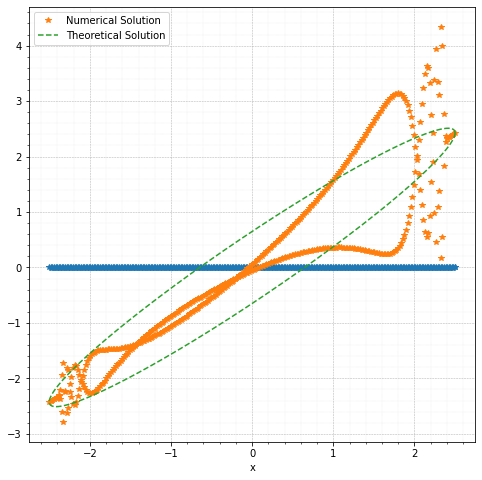

In [158]:
N = 512
U0 = 1 
alpha = 15

## create geometry
t = np.linspace( 0, 1, 512 )
dt = t[1] - t[0] 

a = 2.5
b = .01
c = (a**2-b**2)**.5

X = .5*(a+b) * np.cos( 2 * pi * t )
Y = .5*(a+b) * np.sin( 2 * pi * t )

Z = X + 1j * Y ## circular
z = Z + c**2/(4*Z) ## elliptical
X = np.real(z)
Y = np.imag(z)

## theoretical solution
eta = np.arctan2(np.imag(Z), np.real(Z))
w = (a+b)*U0*np.cos(eta - alpha*pi/180)

## create system of equations
x, y, theta, A, b = assembleMatrixSystem1( X[:-1], Y[:-1], N, U0, alpha )

## solve system of equations
phi = np.linalg.solve( A, b )

## plot solution
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel('x')
ax.plot( np.concatenate( (x,[x[0]]) ), np.concatenate( (y,[y[0]]) ), '-.*' )

ax.plot( x, phi, '*',label="Numerical Solution" )
ax.plot( np.real(z), np.real(w), '--', label="Theoretical Solution" )
ax.legend()

